In [374]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

from scipy.special import genlaguerre, hermite

In [375]:
"BEAM PARAMETERS"

w0  = 1e-3              # waist at focus (m)
lam = 800e-9            # wavelength (m)
k   = 2*np.pi/lam       # wavevector
zR  = np.pi*w0**2/lam   # Rayleigh length


In [376]:
"SIMULATED REGION"

N  = 5001        # number of pixels on a side, use an odd number to have a point at zero
Lx = 300*w0       # length of the box in the x direction (m)
Ly = 300*w0       # length of the box in the y direction (m)
dx = Lx/(N-1)    # sampling rate along x
dy = Ly/(N-1)    # sampling rate along y

x_axis = np.linspace(-Lx/2, Lx/2, N) 
y_axis = np.linspace(-Ly/2, Ly/2, N) 
grid = np.meshgrid(x_axis, y_axis)

In [377]:
"BEAM EXPRESSIONS"

def R(z):
    if z!=0:
        return z*(1 + (zR/z)**2)
    else:
        return np.inf # infinite radius of curvature at focus

def Gouy(z):
    return np.arctan(z/zR)

def w(z):
    return w0 * np.sqrt(1 + (z/zR)**2)

def GaussianBeam(x, y, z):
    r = np.sqrt(x**2 + y**2)
    return w0/w(z) * np.exp(-r**2/w(z)**2) * np.exp(1j*( k*z + k*r**2/(2*R(z)) - Gouy(z) ) )

def LGBeam(x, y, z, l, p):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    C = np.sqrt( 2*np.math.factorial(p) / (np.pi + np.math.factorial(p+np.abs(l)) ) ) # different normalization than for the GB
    
    return GaussianBeam(x, y, z) \
            * C * genlaguerre(p, np.abs(l))(2*r**2/w(z)**2) * np.exp(-1j*l*theta) * (r*np.sqrt(2)/w(z))**np.abs(l) * np.exp(-1j*Gouy(z)*(np.abs(l)+2*p))

def HGBeam(x, y, z, m, n):
    r = np.sqrt(x**2 + y**2)

    return GaussianBeam(x, y, z) \
            * hermite(m)(np.sqrt(2)*x/w(z)) * hermite(n)(np.sqrt(2)*y/w(z)) * np.exp(-1j*Gouy(z)*(m+n))
    

In [404]:
"PROPAGATION"

def SphFactor(x, y, z): # Spherical phase factor in Fresnel propagation
    return np.exp((x**2 + y**2)*1j*k/(2*z))

def Propagate_Fresnel(field_0, z, grid):
    
    # Multiply by the first exponential factor
    field = field_0 * SphFactor(*grid, z)

    # Perform the 2D FFT
    field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(field))) # fft assumes origin of axis at top left corner, need to fftshift beforehand
    field = field * (Lx/(N-1)) * (Ly/(N-1)) # correct for the sampling rate (related to difference between continuous and discrete FT)

    # Compute the conjugate x and y axis. Their width is appx (N lam z / L)
    FT_x_axis = np.fft.fftshift(np.fft.fftfreq(N, Lx/(N-1)))*lam*z
    FT_y_axis = np.fft.fftshift(np.fft.fftfreq(N, Ly/(N-1)))*lam*z
    FT_grid = np.meshgrid(FT_x_axis, FT_y_axis)

    # Multiply by the second exponential factor
    field_z = field / (1j*lam*z) * np.exp(1j*k*z) * SphFactor(*FT_grid, z)
    
    return field_z, FT_grid

def Propagate_Fraunhofer(field_0, z, grid): # equivalent to Fresnel without the spherical wavefront factors

    # Perform the 2D FFT
    field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(field_0))) # fft assumes origin of axis at top left corner, need to fftshift beforehand
    field = field * (Lx/(N-1)) * (Ly/(N-1)) # correct for the sampling rate (related to difference between continuous and discrete FT)

    # Compute the conjugate x and y axis. Their width is appx (N lam z / L)
    FT_x_axis = np.fft.fftshift(np.fft.fftfreq(N, Lx/(N-1)))*lam*z
    FT_y_axis = np.fft.fftshift(np.fft.fftfreq(N, Ly/(N-1)))*lam*z
    FT_grid = np.meshgrid(FT_x_axis, FT_y_axis)

    # Multiply by the second exponential factor
    field_z = field / (1j*lam*z) * np.exp(1j*k*z)
    
    return field_z, FT_grid

In [409]:
"PROPAGATION"


z0 = 0*zR
z  = 3*zR

field_0 = LGBeam(*grid, z0, 5, 2)

field_z, FT_grid = Propagate_Fresnel(field_0, z-z0, grid)
field_z_frau, FT_grid = Propagate_Fraunhofer(field_0, z-z0, grid)

exact_z = LGBeam(*FT_grid, z, 5, 2)

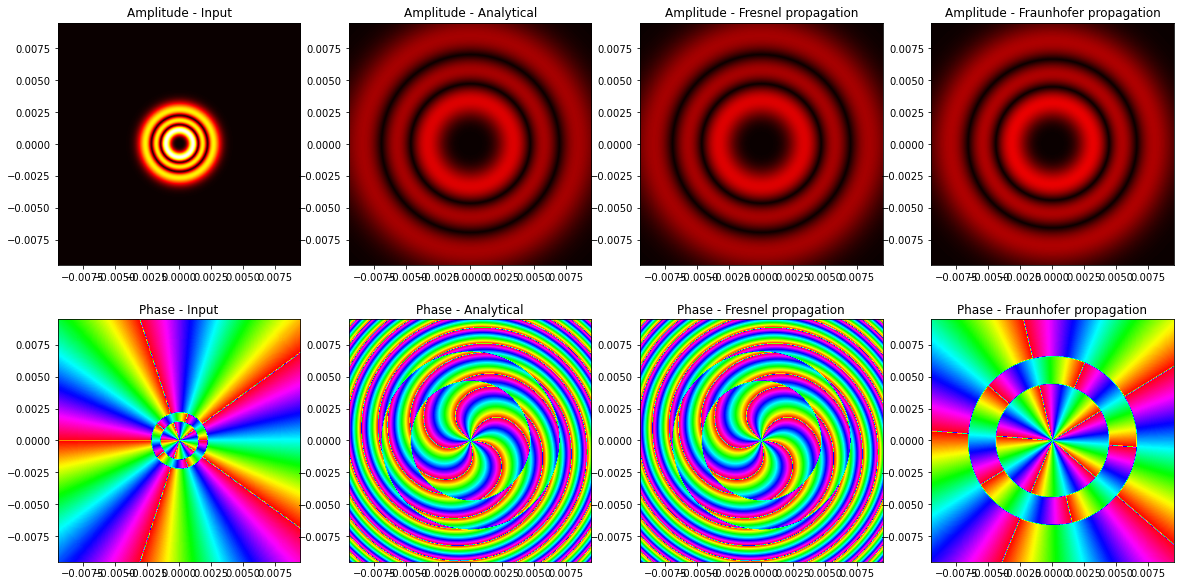

In [410]:
%matplotlib inline
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# Normalize abs to max value at input
Emax = np.max(np.abs(field_0))

# Plot abs of complex field
ax[0, 0].imshow(np.abs(field_0), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2], cmap='hot', vmax=Emax)
ax[0, 1].imshow(np.abs(exact_z), extent=[np.min(FT_grid), np.max(FT_grid), np.min(FT_grid), np.max(FT_grid)], cmap='hot', vmax=Emax)
ax[0, 2].imshow(np.abs(field_z), extent=[np.min(FT_grid), np.max(FT_grid), np.min(FT_grid), np.max(FT_grid)], cmap='hot', vmax=Emax)
ax[0, 3].imshow(np.abs(field_z_frau), extent=[np.min(FT_grid), np.max(FT_grid), np.min(FT_grid), np.max(FT_grid)], cmap='hot', vmax=Emax)


# Plot phase of complex field
ax[1, 0].imshow(np.angle(field_0), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2], cmap='hsv', vmin=-np.pi, vmax=np.pi)
ax[1, 1].imshow(np.angle(exact_z), extent=[np.min(FT_grid), np.max(FT_grid), np.min(FT_grid), np.max(FT_grid)], vmin=-np.pi, vmax=np.pi, cmap='hsv')
ax[1, 2].imshow(np.angle(field_z), extent=[np.min(FT_grid), np.max(FT_grid), np.min(FT_grid), np.max(FT_grid)], vmin=-np.pi, vmax=np.pi, cmap='hsv')
ax[1, 3].imshow(np.angle(field_z_frau), extent=[np.min(FT_grid), np.max(FT_grid), np.min(FT_grid), np.max(FT_grid)], vmin=-np.pi, vmax=np.pi, cmap='hsv')
                                             
lim = 3*w(z)

ax[0, 0].set_xlim(-lim, lim)
ax[0, 0].set_ylim(-lim, lim)

ax[0, 1].set_xlim(-lim, lim)
ax[0, 1].set_ylim(-lim, lim)

ax[0, 2].set_xlim(-lim, lim)
ax[0, 2].set_ylim(-lim, lim)

ax[0, 3].set_xlim(-lim, lim)
ax[0, 3].set_ylim(-lim, lim)

ax[1, 0].set_xlim(-lim, lim)
ax[1, 0].set_ylim(-lim, lim)

ax[1, 1].set_xlim(-lim, lim)
ax[1, 1].set_ylim(-lim, lim)

ax[1, 2].set_xlim(-lim, lim)
ax[1, 2].set_ylim(-lim, lim)

ax[1, 3].set_xlim(-lim, lim)
ax[1, 3].set_ylim(-lim, lim)


ax[0, 0].set_title('Amplitude - Input')
ax[0, 1].set_title('Amplitude - Analytical')
ax[0, 2].set_title('Amplitude - Fresnel propagation')
ax[0, 3].set_title('Amplitude - Fraunhofer propagation')

ax[1, 0].set_title('Phase - Input')
ax[1, 1].set_title('Phase - Analytical')
ax[1, 2].set_title('Phase - Fresnel propagation')
ax[1, 3].set_title('Phase - Fraunhofer propagation')

plt.show()